In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import numpy as np

In [2]:
# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

## preprocessing -- creating masked histograms for the 5 degree spherical cap statistics

In [13]:
data_piC = np.loadtxt("odiv-230/node_files/SH_stormtraj.csv", delimiter="\t", skiprows=1 )
#data_hist = np.loadtxt("CM4_historical/traj_ens.csv", delimiter ="\t", skiprows=1)
#data_585 = np.loadtxt("CM4_585/traj_ens.csv", delimiter ="\t", skiprows=1)

data = data_piC

In [14]:
lat_edges = np.arange(-90,91,1)
lon_edges = np.arange(0, 360.1, 1.25)

lat = np.arange(-89.5,90, 1)
lon = np.arange(.625, 360, 1.25)

ds_kernel = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/kernel/kernel_mask.nc")
time_full = ds_kernel.time.data

In [15]:
season = "none" # choose "none" for full year
if season == "DJF":
    seas =  ((data[:,2]  == 12) | (data[:,2]  <= 2)) #DJF
    heatmap, xedges, yedges = np.histogram2d(data[seas,6], data[seas,5], bins=[lat_edges, lon_edges])
elif season == "JJA":
    seas = ((data[:,2] >= 6) & (data[:,2] <= 8)) #JJA
    heatmap, xedges, yedges = np.histogram2d(data[seas,6], data[seas,5], bins=[lat_edges, lon_edges])
else:
    heatmap, xedges, yedges = np.histogram2d(data[:,6], data[:,5], bins=[lat_edges, lon_edges])

In [16]:
heatmap_3d = np.expand_dims(heatmap, 2)
heatmap_3d_repeat = np.repeat(heatmap_3d, 21900, axis=2)

da = xr.DataArray(
    data = np.transpose(heatmap_3d_repeat[:,:,:15840], axes=[2,0,1]),
    dims = ["time", "lat", "lon"],
    coords = dict(
        lon = ("lon", lon),
        lat = ("lat", lat),
        time = ("time", time_full[:15840])
    ),
    attrs = dict(
        description="Storm density in CM4p125 preindustrial run"
    )
)

ds_out = da.to_dataset(name="storm_dens")

if ((season == "JJA")| (season == "DJF")):
    ds_out.to_netcdf(f"/work/Katherine.Turner/tempest-extremes/kernel/histogram_odiv230_3d_{season}.nc")
else:
    ds_out.to_netcdf(f"/work/Katherine.Turner/tempest-extremes/kernel/histogram_odiv230_3d.nc")

## Part 0 - spherical cap statistics for storm tracks in piControl runs across resolution

In [35]:
ds1  = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/kernel/mhist_odiv251_3d.nc")
ds2  = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/kernel/mhist_odiv230_3d.nc")
ds3  = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/kernel/mhist_odiv209_3d.nc")

In [36]:
hist_251 = np.reshape(ds1.storm_dens.sum(dim=["lat", "lon"]).data / (95*12), (288,55)).T

hist_230 = np.reshape(ds2.storm_dens.sum(dim=["lat", "lon"]).data / (100*12), (288,55)).T

hist_209 = np.reshape(ds3.storm_dens.sum(dim=["lat", "lon"]).data / (100*12), (288,55)).T

lat_plot = np.arange(-90,-34, 1)
lon_plot = np.arange(0, 360, 1.25)

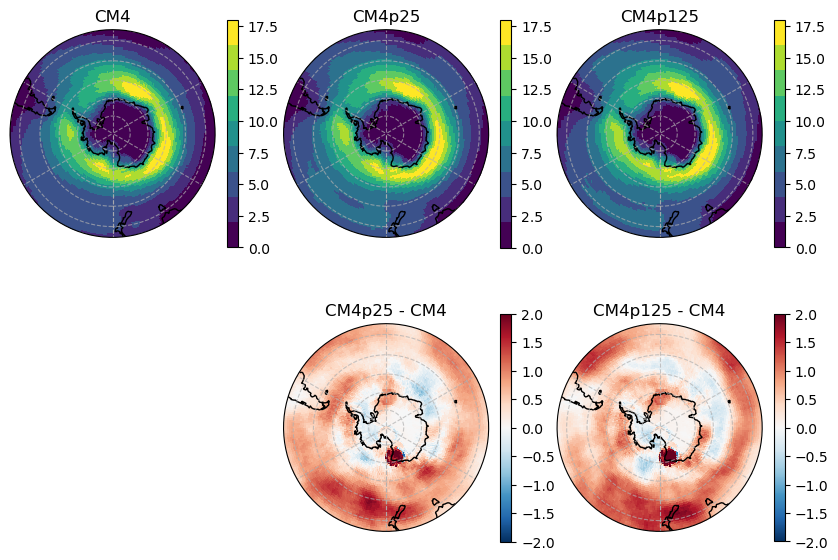

In [43]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize=(10, 7),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()

f0 = axs[0].pcolormesh(lon_plot, lat_plot, hist_251, cmap=plt.get_cmap("viridis", 9),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=18)   
plt.colorbar(f0, ax=axs[0], aspect=20, fraction = .05)
axs[0].set_title("CM4")

f0 = axs[1].pcolormesh(lon_plot, lat_plot, hist_230, cmap=plt.get_cmap("viridis", 9),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=18)      
plt.colorbar(f0, ax=axs[1], aspect=20, fraction = .05)
axs[1].set_title("CM4p25")

f0 = axs[2].pcolormesh(lon_plot, lat_plot, hist_209, cmap=plt.get_cmap("viridis", 9),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=18)      
plt.colorbar(f0, ax=axs[2], aspect=20, fraction = .05)
axs[2].set_title("CM4p125")

f0 = axs[4].pcolormesh(lon_plot, lat_plot, hist_230 - hist_251,
                 transform=ccrs.PlateCarree(), cmap=plt.get_cmap("RdBu_r"), vmin=-2, vmax=2)  
plt.colorbar(f0, ax=axs[4], aspect=20, fraction = .05)
axs[4].set_title("CM4p25 - CM4")

f0 = axs[5].pcolormesh(lon_plot, lat_plot, hist_209 - hist_251,
                 transform=ccrs.PlateCarree(), cmap=plt.get_cmap("RdBu_r"), vmin=-2, vmax=2)    
plt.colorbar(f0, ax=axs[5], aspect=20, fraction = .05)
axs[5].set_title("CM4p125 - CM4")

fig.delaxes(axs[3])

for i in np.arange(6):
    axs[i].set_extent([-180, 180, -90, -35], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7, linestyle='--')
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig("/home/Katherine.Turner/stormdensity_resolution_annual.png", bbox_inches="tight",
            format="png", dpi = 100)

## Part 1 - spherical cap statistics for storm tracks in piControl/historical/SSP 585 runs

In [23]:
ds1  = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/kernel/mhist_odiv251_3d_JJA.nc")
ds2  = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/kernel/mhist_hist_3d_JJA.nc")
ds3  = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/kernel/mhist_585_3d_JJA.nc")

In [24]:
hist_p = np.reshape(ds1.storm_dens.sum(dim=["lat", "lon"]).data / (95*3), (288,55)).T
hist_p2 = np.where(hist_p < 2, np.nan, hist_p)

hist_h = np.reshape(ds2.storm_dens.sum(dim=["lat", "lon"]).data / (90*3), (288,55)).T
hist_h2 = np.where(hist_h < 2, np.nan, hist_h)

hist_5 = np.reshape(ds3.storm_dens.sum(dim=["lat", "lon"]).data / (90*3), (288,55)).T
hist_52 = np.where(hist_5 < 2, np.nan, hist_5)

In [9]:
lat_plot = np.arange(-90,-34, 1)
lon_plot = np.arange(0, 360, 1.25)

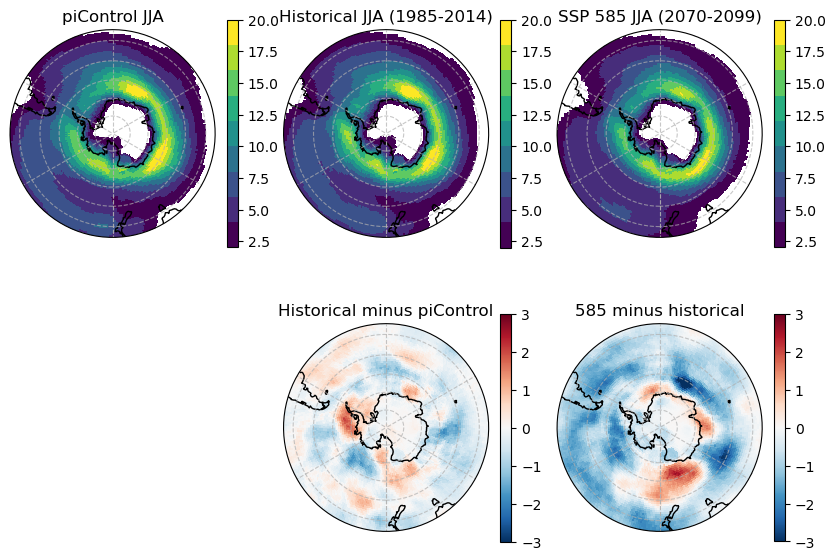

In [25]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize=(10, 7),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()

f0 = axs[0].pcolormesh(lon_plot, lat_plot, hist_p2, cmap=plt.get_cmap("viridis", 9),
                 transform=ccrs.PlateCarree(), vmin=2, vmax=20)   
plt.colorbar(f0, ax=axs[0], aspect=20, fraction = .05)
axs[0].set_title("piControl JJA")

f0 = axs[1].pcolormesh(lon_plot, lat_plot, hist_h2, cmap=plt.get_cmap("viridis", 9),
                 transform=ccrs.PlateCarree(), vmin=2, vmax=20)   
plt.colorbar(f0, ax=axs[1], aspect=20, fraction = .05)
axs[1].set_title("Historical JJA (1985-2014)")

f0 = axs[2].pcolormesh(lon_plot, lat_plot, hist_52, cmap=plt.get_cmap("viridis", 9),
                 transform=ccrs.PlateCarree(), vmin=2, vmax=20)   
plt.colorbar(f0, ax=axs[2], aspect=20, fraction = .05)
axs[2].set_title("SSP 585 JJA (2070-2099)")

f0 = axs[4].pcolormesh(lon_plot, lat_plot, hist_h - hist_p,
                 transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap=plt.get_cmap("RdBu_r"))   
plt.colorbar(f0, ax=axs[4], aspect=20, fraction = .05)
axs[4].set_title("Historical minus piControl")

f0 = axs[5].pcolormesh(lon_plot, lat_plot, hist_5 - hist_h,
                 transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap=plt.get_cmap("RdBu_r"))    
plt.colorbar(f0, ax=axs[5], aspect=20, fraction = .05)
axs[5].set_title("585 minus historical")

fig.delaxes(axs[3])

for i in np.arange(6):
    axs[i].set_extent([-180, 180, -90, -35], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7, linestyle='--')
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig("/home/Katherine.Turner/stormdensity_scenarios_JJA2.png", bbox_inches="tight",
            format="png", dpi = 100)

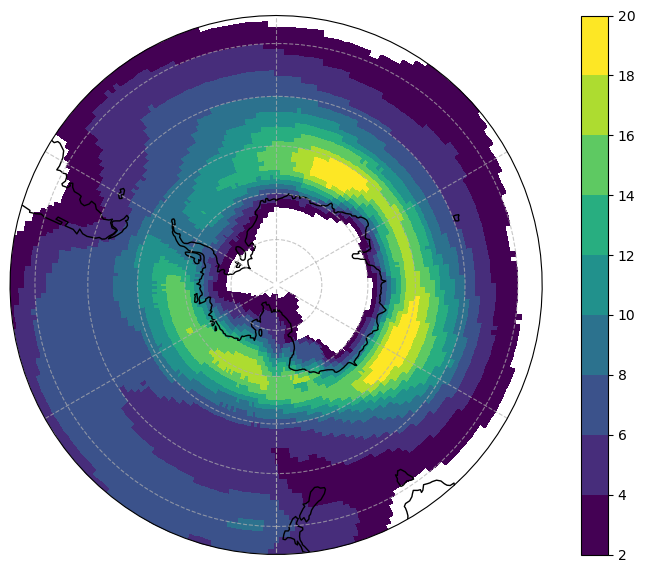

In [92]:
fig, axs = plt.subplots(figsize=(10, 7),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

f0 = axs.pcolormesh(lon_plot, lat_plot, test_plot, cmap=plt.get_cmap("viridis", 9),
                 transform=ccrs.PlateCarree(), vmin=2, vmax=18)   
plt.colorbar(f0, ax=axs)

axs.set_extent([-180, 180, -90, -35], ccrs.PlateCarree())
axs.gridlines(alpha=0.7, linestyle='--')
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()

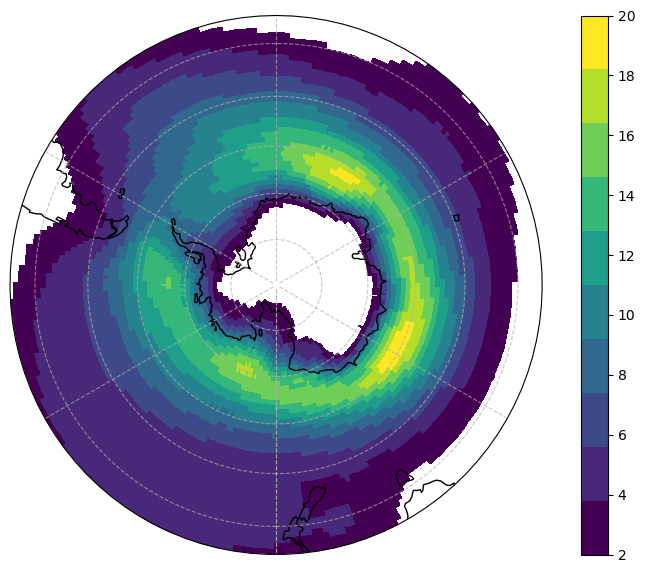

In [77]:
fig, axs = plt.subplots(figsize=(10, 7),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

f0 = axs.pcolormesh(lon_plot, lat_plot, test_plot, cmap=plt.get_cmap("viridis", 10),
                 transform=ccrs.PlateCarree(), vmin=2, vmax=20)   
plt.colorbar(f0, ax=axs)

axs.set_extent([-180, 180, -90, -35], ccrs.PlateCarree())
axs.gridlines(alpha=0.7, linestyle='--')
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()

In [ ]:
hist_5deg = np.ones((21900, 180, 288))*np.nan

for i in np.arange(21900):
    hist_5deg[i,:,:] = (ds_hist.storm_dens * ds_kernel.mask[i,:,:]).data
    if i%219 ==0:
        print(i%219)

In [ ]:
test = xr.where(ds_kernel.mask[i,:,:], ds_hist.storm_dens, 0)

In [ ]:
for i in np.arange(len(lon)):
    for j in np.arange(len(lat)):
        hist_5deg[i,j] = (ds_hist.storm_dens*ds_kernel.mask[i*60+j,:,:]).sum(dim=["lat", "lon"]).data

In [ ]:
plt.pcolormesh(hist_5deg)

## Original histogram code - 21 August 2023

In [ ]:
lat_edges = np.arange(-90,-29,2)
lon_edges = np.arange(0, 361, 5)

In [ ]:
heatmap_piC, xedges, yedges = np.histogram2d(data_piC[:,6], data_piC[:,5], bins=[lat_edges, lon_edges])
heatmap_hist, xedges, yedges = np.histogram2d(data_hist[:,6], data_hist[:,5], bins=[lat_edges, lon_edges])
heatmap_585, xedges, yedges = np.histogram2d(data_585[:,6], data_585[:,5], bins=[lat_edges, lon_edges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, axs = plt.subplots(figsize=(10, 7), ncols = 3, nrows = 2,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()

f0 = axs[0].pcolormesh(yedges, xedges, heatmap_piC/95, cmap=plt.get_cmap('bone_r', 16),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=20)   
plt.colorbar(f0, ax=axs[0], aspect=20, fraction = .05)
axs[0].set_title("piControl")

f0 = axs[1].pcolormesh(yedges, xedges, heatmap_hist/90, cmap=plt.get_cmap('bone_r', 16),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=20)   
plt.colorbar(f0, ax=axs[1], aspect=20, fraction = .05)

axs[1].set_title("Historical (1985-2014)")

f0 = axs[2].pcolormesh(yedges, xedges, heatmap_585/90, cmap=plt.get_cmap('bone_r', 16),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=20)   
plt.colorbar(f0, ax=axs[2], aspect=20, fraction = .05)

axs[2].set_title("Historical (2070-2099)")

f0 = axs[4].pcolormesh(yedges, xedges, heatmap_hist/90-heatmap_piC/95, cmap=plt.get_cmap("RdBu_r", 20),
                 transform=ccrs.PlateCarree(), vmin=-2, vmax=2)   
plt.colorbar(f0, ax=axs[4], aspect=20, fraction = .05)

axs[4].set_title("Historical minus piControl")

f0 = axs[5].pcolormesh(yedges, xedges, heatmap_585/90-heatmap_hist/90, cmap=plt.get_cmap("RdBu_r", 20),
                 transform=ccrs.PlateCarree(), vmin=-2, vmax=2)   
plt.colorbar(f0, ax=axs[5], aspect=20, fraction = .05)

axs[5].set_title("SSP 585 minus historical")

fig.delaxes(axs[3])

for i in np.arange(6):
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    #axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig("/home/Katherine.Turner/stormdensity_scenarios.png", bbox_inches="tight", format="png", dpi=100)

In [ ]:
jja_piC =  ((data_piC[:,2]  >= 3) & (data_piC[:,2]  <= 5))
jja_hist = ((data_hist[:,2] >= 3) & (data_hist[:,2] <= 5))
jja_585 = ((data_585[:,2] >= 3) & (data_585[:,2] <= 5))

heatmap_piC, xedges, yedges = np.histogram2d(data_piC[jja_piC,6], data_piC[jja_piC,5], bins=[lat_edges, lon_edges])
heatmap_hist, xedges, yedges = np.histogram2d(data_hist[jja_hist,6], data_hist[jja_hist,5], bins=[lat_edges, lon_edges])
heatmap_585, xedges, yedges = np.histogram2d(data_585[jja_585,6], data_585[jja_585,5], bins=[lat_edges, lon_edges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, axs = plt.subplots(figsize=(10, 7), ncols = 3, nrows = 2,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()

f0 = axs[0].pcolormesh(yedges, xedges, heatmap_piC/95, cmap=plt.get_cmap('bone_r', 16),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=5)   
plt.colorbar(f0, ax=axs[0], aspect=20, fraction = .05)
axs[0].set_title("piControl MAM")

f0 = axs[1].pcolormesh(yedges, xedges, heatmap_hist/90, cmap=plt.get_cmap('bone_r', 16),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=5)   
plt.colorbar(f0, ax=axs[1], aspect=20, fraction = .05)

axs[1].set_title("Historical MAM (1985-2014)")

f0 = axs[2].pcolormesh(yedges, xedges, heatmap_585/90, cmap=plt.get_cmap('bone_r', 16),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=5)   
plt.colorbar(f0, ax=axs[2], aspect=20, fraction = .05)

axs[2].set_title("Historical MAM (2070-2099)")

f0 = axs[4].pcolormesh(yedges, xedges, heatmap_hist/90-heatmap_piC/95, cmap=plt.get_cmap("RdBu_r", 20),
                 transform=ccrs.PlateCarree(), vmin=-1, vmax=1)   
plt.colorbar(f0, ax=axs[4], aspect=20, fraction = .05)

axs[4].set_title("Historical minus piControl")

f0 = axs[5].pcolormesh(yedges, xedges, heatmap_585/90-heatmap_hist/90, cmap=plt.get_cmap("RdBu_r", 20),
                 transform=ccrs.PlateCarree(), vmin=-1, vmax=1)   
plt.colorbar(f0, ax=axs[5], aspect=20, fraction = .05)

axs[5].set_title("SSP 585 minus historical")

fig.delaxes(axs[3])

for i in np.arange(6):
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    #axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig("/home/Katherine.Turner/stormdensity_scenarios_MAM.png", bbox_inches="tight", format="png", dpi=100)

In [ ]:
son_piC =  ((data_piC[:,2]  == 12) | (data_piC[:,2]  <= 2))
son_hist = ((data_hist[:,2] == 12) | (data_hist[:,2] <= 2))
son_585 = ((data_585[:,2] == 12) | (data_585[:,2] <= 2))

heatmap_piC, xedges, yedges = np.histogram2d(data_piC[son_piC,6], data_piC[son_piC,5], bins=[lat_edges, lon_edges])
heatmap_hist, xedges, yedges = np.histogram2d(data_hist[son_hist,6], data_hist[son_hist,5], bins=[lat_edges, lon_edges])
heatmap_585, xedges, yedges = np.histogram2d(data_585[son_585,6], data_585[son_585,5], bins=[lat_edges, lon_edges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, axs = plt.subplots(figsize=(10, 7), ncols = 3, nrows = 2,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()

f0 = axs[0].pcolormesh(yedges, xedges, heatmap_piC/95, cmap=plt.get_cmap('bone_r', 16),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=5)   
plt.colorbar(f0, ax=axs[0], aspect=20, fraction = .05)
axs[0].set_title("piControl DJF")

f0 = axs[1].pcolormesh(yedges, xedges, heatmap_hist/90, cmap=plt.get_cmap('bone_r', 16),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=5)   
plt.colorbar(f0, ax=axs[1], aspect=20, fraction = .05)

axs[1].set_title("Historical DJF (1985-2014)")

f0 = axs[2].pcolormesh(yedges, xedges, heatmap_585/90, cmap=plt.get_cmap('bone_r', 16),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=5)   
plt.colorbar(f0, ax=axs[2], aspect=20, fraction = .05)

axs[2].set_title("Historical DJF (2070-2099)")

f0 = axs[4].pcolormesh(yedges, xedges, heatmap_hist/90-heatmap_piC/95, cmap=plt.get_cmap("RdBu_r", 20),
                 transform=ccrs.PlateCarree(), vmin=-1, vmax=1)   
plt.colorbar(f0, ax=axs[4], aspect=20, fraction = .05)

axs[4].set_title("Historical minus piControl")

f0 = axs[5].pcolormesh(yedges, xedges, heatmap_585/90-heatmap_hist/90, cmap=plt.get_cmap("RdBu_r", 20),
                 transform=ccrs.PlateCarree(), vmin=-1, vmax=1)   
plt.colorbar(f0, ax=axs[5], aspect=20, fraction = .05)

axs[5].set_title("SSP 585 minus historical")

fig.delaxes(axs[3])

for i in np.arange(6):
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    #axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig("/home/Katherine.Turner/stormdensity_scenarios_DJF.png", bbox_inches="tight", format="png", dpi=100)